# Neural Networks (CSE 40868) Final Project
--- 
### Ryan O'Halloran

In [1]:
### Load libraries ###
from keras.models import Model
import os
import numpy as np
from PIL import Image
from PIL import ImageFile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


#### Defining paths to my training, validation, and test datasets
## **Skip the following block if you are running to test my project**

In [2]:
# Define paths to the training, validation, and test data 
TRAINING_PATH   = '/content/drive/MyDrive/NeuralNetworks/Project/sets/training'
VALIDATION_PATH = '/content/drive/MyDrive/NeuralNetworks/Project/sets/validation'
TEST_PATH       = '/content/drive/MyDrive/NeuralNetworks/Project/sets/test'

### Encoder Models
---
##### Includes:
 - **Encoder**: Original Encoder seen in Project Part 3 

 - **NewEncoder**: Updated and improved version of the original Encoder model
 
 - **WindowEncoder**: Encoder model implementing 'sliding window' approach to denoising

In [3]:
# Original encoder model
class Encoder(nn.Module):
    def __init__(self, input_shape, encoded_dim):
        super().__init__()
        channels, height, width = input_shape
        
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(128 * (height//8) * (width//8), encoded_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Updated encoder model
class NewEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        channels, height, width = input_shape
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(256 * (height // 16) * (width // 16), latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Windowed encoder model
class WindowEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim=128):
        super().__init__()
        channels, height, width = input_shape
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(256 * (height // 8) * (width // 8), latent_dim)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x = x.unfold(2, 64, 64).unfold(3, 64, 64)
        x = x.contiguous().view(batch_size, channels, -1, 64, 64)
        x = x.permute(0, 2, 1, 3, 4)
        x = x.contiguous().view(-1, channels, 64, 64)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(batch_size, -1, 256 * (height // 8) * (width // 8))
        x = x.mean(dim=1)
        x = self.fc(x)
        return x


### Decoder Models
---
##### Includes:
 - **Decoder**: Original Decoder seen in Project Part 3 

 - **NewDecoder**: Updated and improved version of the original Decoder model
 
 - **WindowDecoder**: Decoder model implementing 'sliding window' approach to denoising

In [4]:
# Define decoder models

# Original decoder model
class Decoder(nn.Module):
    def __init__(self, encoded_dim, output_shape):
        super().__init__()
        self.fc1 = nn.Linear(encoded_dim, 256 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 256, 16, 16)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        x = F.interpolate(x, size=(512,512), mode='bilinear', align_corners=False)
        return x

# Updated decoder model
class NewDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.channels, self.height, self.width = output_shape
        self.fc = nn.Linear(latent_dim, 256 * (self.height // 16) * (self.width // 16))
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, self.channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 256, (self.height // 16), (self.width // 16))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x

# Windowed decoder model
class WindowDecoder(nn.Module):
    def __init__(self, output_shape, latent_dim=128):
        super().__init__()
        self.channels, self.height, self.width = output_shape
        self.fc = nn.Linear(latent_dim, 256 * (self.height // 8) * (self.width // 8))
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(32, self.channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 256, (self.height // 8), (self.width // 8))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x

#### Retrieve lists of dataset filenames
## **Skip the following block if you are running to test my project**

In [5]:
# Define train, validation, and test sets
training_files = sorted(os.listdir(TRAINING_PATH))
training_files_midpoint = int(len(training_files)/8)
train_data = [('noisy_'+file, file) for file in training_files[:training_files_midpoint]]

print(f'Number of training pairs: \t{len(train_data)}')

validation_files = sorted(os.listdir(VALIDATION_PATH))
validation_files_midpoint = int(len(validation_files)/8)
validation_data = [('noisy_'+file, file) for file in validation_files[:validation_files_midpoint]]

print(f'Number of validation pairs: \t{len(validation_data)}')

test_files = sorted(os.listdir(TEST_PATH))
test_files_midpoint = int(len(test_files)/8)
test_data = [('noisy_'+file, file) for file in test_files[:test_files_midpoint]]

print(f'Number of test pairs: \t\t{len(test_data)}')

Number of training pairs: 	900
Number of validation pairs: 	300
Number of test pairs: 		300


In [6]:
# Define data transformation (just converting to tensor for now)
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

#### Define dataloader for loading and converting images to tensors

In [7]:
# Define a dataloader
class DenoiseDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, path, transform=None):
        self.data_list = data_list
        self.transform = transform
        self.path = path

    def __getitem__(self, index):
        noisy_file, clean_file = self.data_list[index]
        noisy_img = Image.open(os.path.join(self.path, noisy_file))
        clean_img = Image.open(os.path.join(self.path, clean_file))
        noisy_tensor = self.transform(noisy_img)
        clean_tensor = self.transform(clean_img)
        return {'noisy': noisy_tensor, 'clean': clean_tensor}

    def __len__(self):
        return len(self.data_list)


#### Load data into training, validation, and test sets

In [8]:
# Load data for each dataset
train_dataset = DenoiseDataset(train_data, path=TRAINING_PATH, transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

validation_dataset = DenoiseDataset(validation_data, path=VALIDATION_PATH, transform=data_transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True)

test_dataset = DenoiseDataset(test_data, path=TEST_PATH, transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

#### Define device for training (for this, just use CPU)

In [9]:
# Define the device to be used for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Define paths to my model weights
## **Skip the following block if you are running to test my project**

In [10]:
# Define paths to my models
my_best_model       = "/content/drive/MyDrive/NeuralNetworks/best_model.pth"
new_best_model      = "/content/drive/MyDrive/NeuralNetworks/new_best_model.pth"
window_best_model   = "/content/drive/MyDrive/NeuralNetworks/window_best_model.pth"

### Denoising Autoencoder Full Models
---
##### Includes:
 - **DenoisingAutoencoder**: Original Denoising Autoencoder seen in Project Part 3. Uses ***Encoder*** and ***Decoder*** models.

 - **NewDenoisingAutoencoder**: Updated and improved version of the original Denoising Autoencoder model. Uses ***NewEncoder*** and ***NewDecoder*** models.

 - **WindowDenoisingAutoencoder**: Denoising Autoencoder model implementing 'sliding window' approach to denoising. Uses ***WindowEncoder*** and ***WindowDecoder*** models.

In [11]:
# Define denoising autoencoder models

# Original model
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_shape, encoded_dim):
        super().__init__()
        self.encoder = Encoder(input_shape, encoded_dim)
        self.decoder = Decoder(encoded_dim, input_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Updated model (additional convolutional layer)
class NewDenoisingAutoencoder(nn.Module):
    def __init__(self, input_shape, encoded_dim):
        super().__init__()
        self.encoder = NewEncoder(input_shape, encoded_dim)
        self.decoder = NewDecoder(encoded_dim, input_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Windowed model (using sliding window approach)
class WindowDenoisingAutoencoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.encoder = WindowEncoder(input_shape)
        self.decoder = WindowDecoder(input_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the input/output shapes and encoding dimensions
input_shape = (1, 512, 512)
latent_dim = 64
old_encoded_dim = 64
new_encoded_dim = 64
windowed_latent_dim = 128


# Create instances of the different DenoisingAutoencoder models
model = DenoisingAutoencoder(input_shape=input_shape, encoded_dim=old_encoded_dim)
new_model = NewDenoisingAutoencoder(input_shape=input_shape, encoded_dim=new_encoded_dim)
window_model = WindowDenoisingAutoencoder(input_shape=input_shape)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training block
---
Trains the model specified by the ***chosen_model*** and ***chosen_model_weights*** variables.

(Saves the model selected with ***chosen_model*** to the path pointed to by ***chosen_model***_weights).

## **Skip the following block if you are running to test my project**

In [ ]:
# Train the model (setup right now to train on original model)
num_epochs = 4
best_loss = float('inf')

chosen_model = window_model
chosen_model_weights = window_best_model

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_loader, 0)):

        inputs, targets = batch['noisy'], batch['clean']
        
        inputs_data = inputs.to(device)
        targets_data = targets.to(device)

        optimizer.zero_grad()

        outputs = chosen_model(inputs_data)

        loss = criterion(outputs, targets_data)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/100}')
            running_loss = 0.0

    # Evaluate the model on the validation set and save the best model
    val_loss = 0.0
    with torch.no_grad():
        for data in validation_loader:
            inputs, targets = data['noisy'], data['clean']
            inputs_data = inputs.to(device)
            targets_data = targets.to(device)
            outputs = chosen_model(inputs_data)
            val_loss += criterion(outputs, targets_data).item()

    val_loss /= len(validation_loader)
    print('Validation loss: %.3f' % val_loss)

    if val_loss < best_loss:
        print('Saving model state...')
        torch.save(chosen_model.state_dict(), chosen_model_weights)
        best_loss = val_loss

print('Finished training.')


#### Function to test a specified model's accuracy

## **Skip the following block if you are running to test my project**
### (I have a later block dedicated for individual testing)

In [19]:
def test_model_loss(chosen_test_model, chosen_test_model_path, chosen_model_name):
    # Load the test model
    chosen_test_model.load_state_dict(torch.load(chosen_test_model_path))

    # Switch to eval mode
    chosen_test_model.eval()

    # Test the model on the test dataset
    test_loss = 0.0
    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs, targets = data['noisy'], data['clean']
            inputs_data = inputs.to(device)
            targets_data = targets.to(device)
            outputs = chosen_test_model(inputs_data)
            test_loss += criterion(outputs, targets_data).item()

    test_loss /= len(test_loader)
    print(f'{chosen_model_name} test loss: {test_loss:.3f}')

#### Test each model's losses
## **Skip the following block if you are running to test my project**

In [20]:
test_model_loss(chosen_test_model=model, chosen_test_model_path=my_best_model, chosen_model_name='Original Model')
test_model_loss(chosen_test_model=new_model, chosen_test_model_path=new_best_model, chosen_model_name='New Model')
test_model_loss(chosen_test_model=window_model, chosen_test_model_path=window_best_model, chosen_model_name='Window Model')

 22%|██▏       | 67/300 [00:22<01:41,  2.29it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 4, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 300/300 [01:38<00:00,  3.03it/s]


Original Model test loss: 0.009


100%|██████████| 300/300 [02:13<00:00,  2.25it/s]


New Model test loss: 0.008


100%|██████████| 300/300 [04:58<00:00,  1.00it/s]

Window Model test loss: 0.013


### Function to visually display the model's ability to reconstruct the images

In [12]:
def show_test_model(clean_image, noisy_image, selected_model, model_path, plot_title):
    # Load the model from the saved state dict
    selected_model.load_state_dict(torch.load(model_path), strict=False)
    selected_model.eval()

    # Load the clean and noisy images from the filenames
    clean_image_data = Image.open(clean_image).convert('L')
    noisy_image_data = Image.open(noisy_image).convert('L')

    # Apply the image transforms and add a batch dimension to the noisy image
    clean_image_tensor = data_transform(clean_image_data).unsqueeze(0).to(device)
    noisy_image_tensor = data_transform(noisy_image_data).unsqueeze(0).to(device)

    # Run the noisy image through the model to get the cleaned image
    cleaned_image_tensor = selected_model(noisy_image_tensor)

    # Convert the tensors to PIL images and display them
    clean_image_pil = transforms.ToPILImage()(clean_image_tensor.squeeze().cpu())
    noisy_image_pil = transforms.ToPILImage()(noisy_image_tensor.squeeze().cpu())
    cleaned_image_pil = transforms.ToPILImage()(cleaned_image_tensor.squeeze().cpu())

    # Show the images with their titles
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(clean_image_pil, cmap='gray')
    axs[0].set_title('Clean image')
    axs[1].imshow(noisy_image_pil, cmap='gray')
    axs[1].set_title('Noisy image')
    axs[2].imshow(cleaned_image_pil, cmap='gray')
    axs[2].set_title(plot_title)
    
    plt.show()

### Randomly select an image pair from the test data and test each model on it
---
## **Skip the following block if you are running to test my project**

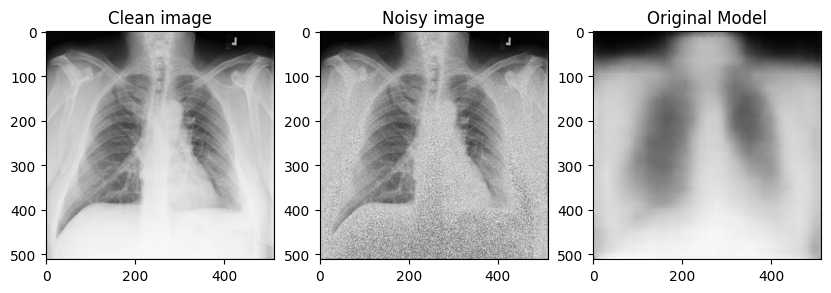

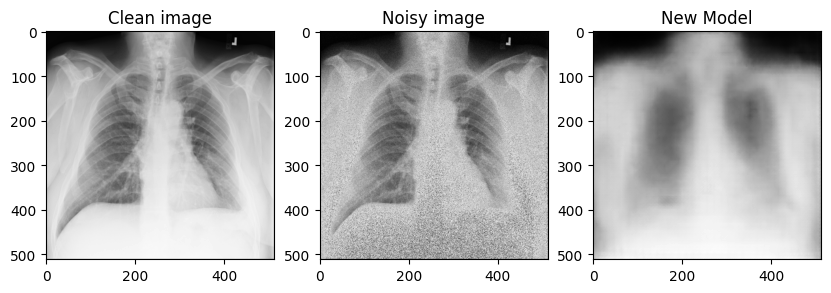

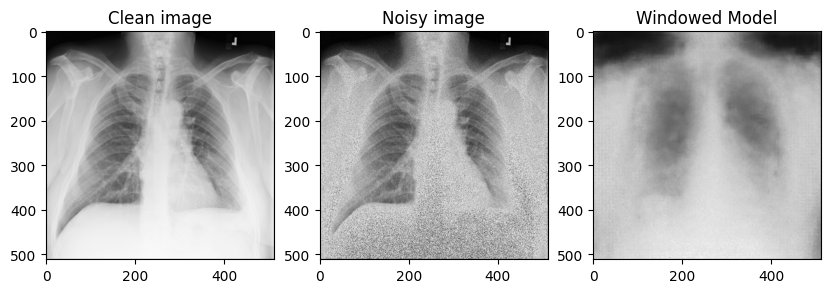

In [18]:
# Show examples of how well the model denoises test data
test_data_len = len(test_data)
rand_idx = random.randint(0, test_data_len-1)
noisy_image, clean_image = test_data[rand_idx]
noisy_path = os.path.join(TEST_PATH, noisy_image)
clean_path = os.path.join(TEST_PATH, clean_image)

# Show original model's result
show_test_model(clean_image=clean_path, noisy_image=noisy_path, selected_model=model, model_path=my_best_model, plot_title='Original Model')
# Show updated model's result
show_test_model(clean_image=clean_path, noisy_image=noisy_path, selected_model=new_model, model_path=new_best_model, plot_title='New Model')
# Show windowed model's result
show_test_model(clean_image=clean_path, noisy_image=noisy_path, selected_model=window_model, model_path=window_best_model, plot_title='Windowed Model')

### Model evaluation for training data
To be compared with the model evaluation on test data (shows there's little difference in performace across data classes)

--- 
## **Skip the following block if you are running to test my project**

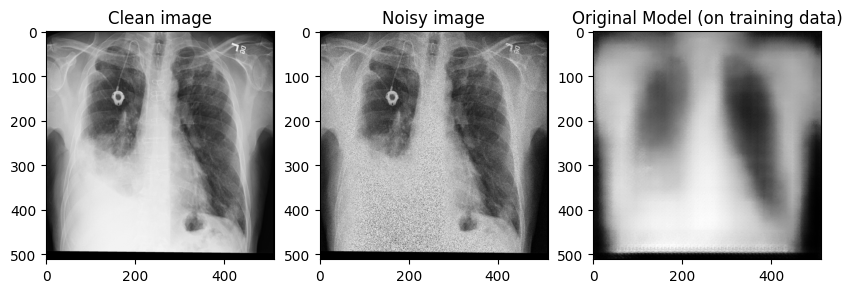

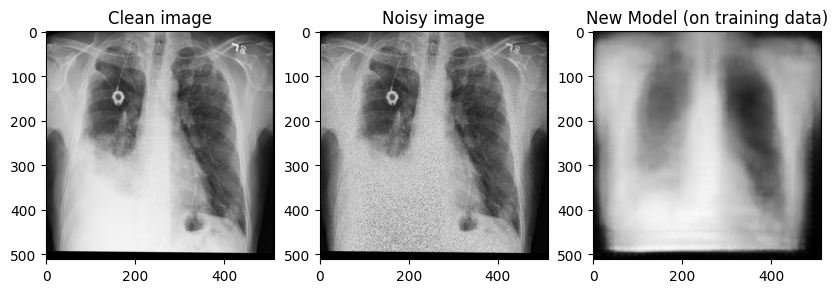

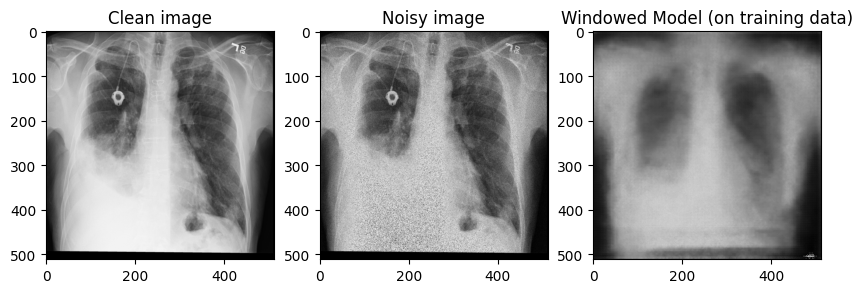

In [22]:
# Show examples of how well the model denoises training data
train_data_len = len(train_data)
train_rand_idx = random.randint(0, train_data_len-1)
train_noisy_image, train_clean_image = train_data[train_rand_idx]
train_noisy_path = os.path.join(TRAINING_PATH, train_noisy_image)
train_clean_path = os.path.join(TRAINING_PATH, train_clean_image)

# Show original model's result
show_test_model(clean_image=train_clean_path, noisy_image=train_noisy_path, selected_model=model, model_path=my_best_model, plot_title='Original Model (on training data)')
# Show updated model's result
show_test_model(clean_image=train_clean_path, noisy_image=train_noisy_path, selected_model=new_model, model_path=new_best_model, plot_title='New Model (on training data)')
# Show windowed model's result
show_test_model(clean_image=train_clean_path, noisy_image=train_noisy_path, selected_model=window_model, model_path=window_best_model, plot_title='Windowed Model (on training data)')

# **For individual testing**
---
- #### Put the paths to your clean and noisy images into the ***clean_image_path*** and ***noisy_image_path*** variables
- #### Put the paths to your model weights into the ***path_to_my_original_model***, ***path_to_my_new_model***, and ***path_to_my_window_model*** variables

In [28]:
# Add your image paths
clean_image_path          = ""
noisy_image_path          = ""
# Add your model path
path_to_my_original_model = ""
path_to_my_new_model      = ""
path_to_my_window_model   = ""

Run this block to test on your images

In [ ]:
# Show original model's result
show_test_model(clean_image=clean_image_path, noisy_image=noisy_image_path, selected_model=model, model_path=path_to_my_original_model, plot_title='Original Model')
# Show updated model's result
show_test_model(clean_image=clean_image_path, noisy_image=noisy_image_path, selected_model=new_model, model_path=path_to_my_new_model, plot_title='New Model')
# Show windowed model's result
show_test_model(clean_image=clean_image_path, noisy_image=noisy_image_path, selected_model=window_model, model_path=path_to_my_window_model, plot_title='Windowed Model')